In [101]:
from collections import namedtuple
import sympy
from sympy import Matrix, det, symbols, sin, cos, pi
from sympy.physics.units import speed_of_light, meter, second, convert_to, radian
import IPython.display

In [102]:
TrackingWheelCfg = namedtuple('TrackingWheelCfg', ['p', 'theta_rad', 'radius_meters'])

Twist = namedtuple("Twist", ["dx", "dy", "dtheta"])
Pose = namedtuple("Pose", ["x", "y", "theta"])

In [103]:
e_x = Matrix([[1],[0]])
e_y = Matrix([[0],[1]])

In [104]:
acfg1 = TrackingWheelCfg(Matrix([['v_x1'], ['v_y1']]) * meter, symbols('o_1') * radian, symbols('r_1')* meter)
acfg2 = TrackingWheelCfg(Matrix([['v_x2'], ['v_y2']]) * meter, symbols('o_2') * radian, symbols('r_2')* meter)
acfg3 = TrackingWheelCfg(Matrix([['v_x3'], ['v_y3']]) * meter, symbols('o_3') * radian, symbols('r_3')* meter)

cfg1 = TrackingWheelCfg(Matrix([-0.04445 * meter, 0.06985 * meter]), 0 * radian, 0.028297632 * meter)
cfg2 = TrackingWheelCfg(Matrix([0.008382 * meter, -0.06985 * meter]), pi * radian, 0.028297632 * meter)
cfg3 = TrackingWheelCfg(Matrix([-0.2032 * meter, -0.0127 * meter]), (3 * pi / 2) * radian, 0.028297632 * meter)

In [105]:
def vectorFromRadians(theta):
    return Matrix([cos(theta), sin(theta)])

In [106]:
rotatePositive90Mat = Matrix([[0,-1],[1,0]])

In [110]:
def f_x(cfg: TrackingWheelCfg):
    d = vectorFromRadians(cfg.theta_rad)
    return cfg.radius_meters * (e_x.dot(d))
def f_xp(cfg: TrackingWheelCfg):
    d = rotatePositive90Mat * vectorFromRadians(cfg.theta_rad)
    return cfg.radius_meters * (e_x.dot(d))

def f_y(cfg: TrackingWheelCfg):
    d = vectorFromRadians(cfg.theta_rad)
    return cfg.radius_meters * (e_y.dot(d))
def f_yp(cfg: TrackingWheelCfg):
    d = rotatePositive90Mat * vectorFromRadians(cfg.theta_rad)
    return cfg.radius_meters * (e_y.dot(d))

def f_o(cfg: TrackingWheelCfg):
    v = cfg.p
    t = rotatePositive90Mat * v.normalized()
    d = vectorFromRadians(cfg.theta_rad)
    return cfg.radius_meters * (t.dot(d)) / v.norm()
def f_op(cfg: TrackingWheelCfg):
    v = cfg.p
    t = rotatePositive90Mat * v.normalized()
    d = rotatePositive90Mat * vectorFromRadians(cfg.theta_rad)
    return cfg.radius_meters * (t.dot(d)) / v.norm()


In [112]:
m1 = Matrix([
    [f_x(acfg1),
    f_y(acfg1),
    f_o(acfg1)],
    [f_xp(acfg1),
    f_yp(acfg1),
    f_op(acfg1)]
])

In [113]:
sympy.simplify(m1 * Matrix(['dx','dy',symbols('d\\theta')]))

Matrix([
[ r_1*(meter*(dx*cos(radian*o_1) + dy*sin(radian*o_1))*(Abs(v_x1)**2 + Abs(v_y1)**2) + d\theta*(v_x1*sin(radian*o_1) - v_y1*cos(radian*o_1)))/(Abs(v_x1)**2 + Abs(v_y1)**2)],
[r_1*(meter*(-dx*sin(radian*o_1) + dy*cos(radian*o_1))*(Abs(v_x1)**2 + Abs(v_y1)**2) + d\theta*(v_x1*cos(radian*o_1) + v_y1*sin(radian*o_1)))/(Abs(v_x1)**2 + Abs(v_y1)**2)]])

Assuming radians to linear distance is a solved problem cuz it kinda is

Things we know:
- $c_\text{perpindicular} + c_\text{parallel} = \text{total motion of point in frame}$
- given a frame twist, what a point on the chassis will experience


Things we measure:
- parallel component of each pod

Things we find:
- Twist of robot frame
- perpindicular component of each pod

In [114]:
def body_twist_to_pod_motion(twist: Twist, pod_position: Matrix)-> Matrix:
    return Matrix([
        [1,0,-pod_position[1]],
        [0,1,pod_position[0]],
    ]) * Matrix([twist.dx, twist.dy, twist.dtheta])

In [115]:
body_twist_to_pod_motion_matrix = Matrix([
        [1,0,-symbols('p_y')],
        [0,1,symbols('p_x')],
    ])

In [116]:
def rotation_matrix2d(theta) -> Matrix:
    return Matrix([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
    

In [117]:
body_twist_to_pod_wheel_motion_matrix = rotation_matrix2d(symbols('p_\\theta')) * body_twist_to_pod_motion_matrix
# Vector of [parallel to wheel, perpindicular to wheel]

In [182]:
Inv = Matrix([
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x1').subs('p_y','p_y1').subs(symbols('p_\\theta'), symbols('p_\\theta1')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x2').subs('p_y','p_y2').subs(symbols('p_\\theta'), symbols('p_\\theta2')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x3').subs('p_y','p_y3').subs(symbols('p_\\theta'), symbols('p_\\theta3'))])

In [183]:
Inv

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[sin(p_\theta1),  cos(p_\theta1),  p_x1*cos(p_\theta1) - p_y1*sin(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[sin(p_\theta2),  cos(p_\theta2),  p_x2*cos(p_\theta2) - p_y2*sin(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)],
[sin(p_\theta3),  cos(p_\theta3),  p_x3*cos(p_\theta3) - p_y3*sin(p_\theta3)]])

In [184]:
InvFilled = Tr \
    .subs(symbols('p_\\theta1'),cfg1.theta_rad / radian) \
    .subs('p_x1', cfg1.p[0] / meter).subs('p_y1', cfg1.p[1] / meter) \
    .subs(symbols('p_\\theta2'),cfg2.theta_rad / radian) \
    .subs('p_x2', cfg2.p[0] / meter).subs('p_y2', cfg2.p[1] / meter) \
    .subs(symbols('p_\\theta3'),cfg3.theta_rad / radian) \
    .subs('p_x3', cfg3.p[0] / meter).subs('p_y3', cfg3.p[1] / meter)


In [185]:
InvFilled

Matrix([
[ 1,  0,  -0.06985],
[ 0,  1,  -0.04445],
[-1,  0,  -0.06985],
[ 0, -1, -0.008382],
[ 0,  1,   -0.2032],
[-1,  0,   -0.0127]])

In [186]:
Inv

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[sin(p_\theta1),  cos(p_\theta1),  p_x1*cos(p_\theta1) - p_y1*sin(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[sin(p_\theta2),  cos(p_\theta2),  p_x2*cos(p_\theta2) - p_y2*sin(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)],
[sin(p_\theta3),  cos(p_\theta3),  p_x3*cos(p_\theta3) - p_y3*sin(p_\theta3)]])

In [188]:
BigMatrix = Inv * Matrix([symbols('dx'),symbols('dy'),symbols('d\\theta')])

In [189]:
BigMatrix

Matrix([
[d\theta*(-p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)) + dx*cos(p_\theta1) - dy*sin(p_\theta1)],
[ d\theta*(p_x1*cos(p_\theta1) - p_y1*sin(p_\theta1)) + dx*sin(p_\theta1) + dy*cos(p_\theta1)],
[d\theta*(-p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)) + dx*cos(p_\theta2) - dy*sin(p_\theta2)],
[ d\theta*(p_x2*cos(p_\theta2) - p_y2*sin(p_\theta2)) + dx*sin(p_\theta2) + dy*cos(p_\theta2)],
[d\theta*(-p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)) + dx*cos(p_\theta3) - dy*sin(p_\theta3)],
[ d\theta*(p_x3*cos(p_\theta3) - p_y3*sin(p_\theta3)) + dx*sin(p_\theta3) + dy*cos(p_\theta3)]])

In [197]:
Inv

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[sin(p_\theta1),  cos(p_\theta1),  p_x1*cos(p_\theta1) - p_y1*sin(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[sin(p_\theta2),  cos(p_\theta2),  p_x2*cos(p_\theta2) - p_y2*sin(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)],
[sin(p_\theta3),  cos(p_\theta3),  p_x3*cos(p_\theta3) - p_y3*sin(p_\theta3)]])

In [201]:
InvLow = Matrix([
    ['F_x1','F_y1',symbols('F_\\theta1')], 
    ['F_x1p','F_y1p',symbols('F_\\theta1p')], 
    ['F_x2','F_y2',symbols('F_\\theta2')],
    ['F_x2p','F_y2p',symbols('F_\\theta2p')],
    ['F_x3','F_y3',symbols('F_\\theta3')],
    ['F_x3p','F_y3p',symbols('F_\\theta3p')]
    ])
InvLow

Matrix([
[ F_x1,  F_y1,  F_\theta1],
[F_x1p, F_y1p, F_\theta1p],
[ F_x2,  F_y2,  F_\theta2],
[F_x2p, F_y2p, F_\theta2p],
[ F_x3,  F_y3,  F_\theta3],
[F_x3p, F_y3p, F_\theta3p]])

In [202]:
InvLow.pinv()

KeyboardInterrupt: 

In [ ]:
I

In [191]:
ForwardFilled = InvFilled.pinv()

In [196]:
ForwardFilled * Matrix(['E_1','E_p1','E_2','E_p2', 'E_p3', 'E_p3'])

Matrix([
[0.34252531313661*E_1 - 0.325191865507574*E_2 - 0.0043806349462474*E_p1 + 0.0109358296859557*E_p2 - 0.316966356723613*E_p3],
[ -0.173176899493737*E_1 - 0.15338525383731*E_2 + 0.415864495720634*E_p1 - 0.53936436461674*E_p2 + 0.0249794940061989*E_p3],
[      -2.1713338117977*E_1 - 1.92318137616368*E_2 + 1.03479565659387*E_p1 - 2.58326685495018*E_p2 - 3.86621494717807*E_p3]])

In [213]:
InvReducedFilled = Matrix([InvFilled.row(r) for r in range(0,InvFilled.rows,2)])

In [212]:
InvFilled

Matrix([
[ 1,  0,  -0.06985],
[ 0,  1,  -0.04445],
[-1,  0,  -0.06985],
[ 0, -1, -0.008382],
[ 0,  1,   -0.2032],
[-1,  0,   -0.0127]])

In [245]:
res = InvReducedFilled.pinv() * Matrix([2,-2,1])
res

Matrix([
[2.0],
[1.0],
[  0]])

In [228]:
InvFilled * res

Matrix([
[               2.0],
[-0.136363636363636],
[              -1.0],
[ 0.514545454545454],
[               1.0],
[ -1.40909090909091]])

# Now for real

Given Pod Positions $\set{P_1, \cdots, P_n}$ where $P_i = (p_{xi}, p_{yi}, p_{\theta i})$

Imagine the position of a pod on the robot just as a point, not as a wheel

Can imagine that each pod has like the optical tracking sensor on it that can show both x and y motion

Given a $(\Delta x, \Delta y, \Delta \theta)$ of the robot frame, that point will move to the following

In [248]:
print("The matrix that when multiplied by the motion of the sensor measurement gives a measurement of the robot frame, gives")
display(body_twist_to_pod_motion_matrix)


The matrix that when multiplied by the motion of the sensor measurement gives a measurement of the robot frame, gives


Matrix([
[1, 0, -p_y],
[0, 1,  p_x]])

The x and y components are the identity. If you move the pod forward 1 unit with no rotation, the robot will move forward one unit

The rotational component is a little trig but im gonna skip that for now bc timelines. WPI lib agrees with me

But, what if our points have a rotation (optical tracking sensor attached at an angle). What we would measure for an x motion for example would register as a y motion if we were rotated by 90 degrees.

To account for this, we rotate our measurements by the rotation of the sensor

In [241]:
body_twist_to_pod_wheel_motion_matrix

Matrix([
[cos(p_\theta), -sin(p_\theta), -p_x*sin(p_\theta) - p_y*cos(p_\theta)],
[sin(p_\theta),  cos(p_\theta),  p_x*cos(p_\theta) - p_y*sin(p_\theta)]])

Rather than reading the identity for x,y motions, we read the rotated identity. Rotation is rotated as well

If we have 3 motion tracking sensors, we can make a big matrix that gives the x and y measurements of each of them

In [242]:
Matrix([
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x1').subs('p_y','p_y1').subs(symbols('p_\\theta'), symbols('p_\\theta1')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x2').subs('p_y','p_y2').subs(symbols('p_\\theta'), symbols('p_\\theta2')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x3').subs('p_y','p_y3').subs(symbols('p_\\theta'), symbols('p_\\theta3'))])

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[sin(p_\theta1),  cos(p_\theta1),  p_x1*cos(p_\theta1) - p_y1*sin(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[sin(p_\theta2),  cos(p_\theta2),  p_x2*cos(p_\theta2) - p_y2*sin(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)],
[sin(p_\theta3),  cos(p_\theta3),  p_x3*cos(p_\theta3) - p_y3*sin(p_\theta3)]])

In [255]:
Conv = Matrix([
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x1').subs('p_y','p_y1').subs(symbols('p_\\theta'), symbols('p_\\theta1')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x2').subs('p_y','p_y2').subs(symbols('p_\\theta'), symbols('p_\\theta2')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x3').subs('p_y','p_y3').subs(symbols('p_\\theta'), symbols('p_\\theta3'))]) 


Now, since we have wheels instead of optical tracking sensors, we lose an axis. Since we've already rotated, lets say our wheel is setup so that its measuring what the x axis of the abstract optical sensor is. the y axis just causes the rollers of the omni wheel to spin and no measurement is mearured.

In doing this, we lose half our measurements but whatevs if we have 3 wheels we have as many degrees of freedom as we do sensors

In [258]:
Reduced = Matrix([Conv.row(i) for i in range(0,6, 2)])
Reduced

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)]])

We drop the rows in the matrix that correspond to those y axis measurements cuz we can never know them.

Now, if we multiply by the encoder deltas (distance, not angles), we get a delta of the frame.

If we were to take the inverse of the non-reduced matrix then multiply by the delta of the frame, we would recover but the encoder deltas we put in as well as the components that were perpindicular to the omni wheel that we couldnt originally measure

In [261]:
sympy.Eq(Reduced * Matrix(['E_1', 'E_2', 'E_3']), Matrix(['d_x', 'd_y', symbols('d_\\theta')]) )

Eq(Matrix([
[E_1*cos(p_\theta1) - E_2*sin(p_\theta1) + E_3*(-p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1))],
[E_1*cos(p_\theta2) - E_2*sin(p_\theta2) + E_3*(-p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2))],
[E_1*cos(p_\theta3) - E_2*sin(p_\theta3) + E_3*(-p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3))]]), Matrix([
[     d_x],
[     d_y],
[d_\theta]]))

Using encoder positions and angles from software robot

In [291]:
InvReducedFilled

Matrix([
[ 1, 0, -0.06985],
[-1, 0, -0.06985],
[ 0, 1,  -0.2032]])

In [304]:
print("Robot drives forward 0.01m, doesnt rotate or move crabwise, encoder readings (distance):")
display(Matrix([0.01,-0.01,0]))
print("When multiplied")
display(InvReducedFilled.pinv() * Matrix([0.01, -0.01, 0]))


Robot drives forward 0.01m, doesnt rotate or move crabwise, encoder readings (distance):


Matrix([
[ 0.01],
[-0.01],
[    0]])

When multiplied


Matrix([
[0.01],
[   0],
[   0]])

In [301]:
InvFilled.pinv() * Matrix([1,0,-1,0,0,-1])

Matrix([
[                 1.0],
[1.04083408558608e-17],
[1.66533453693773e-16]])

In [303]:
InvReducedFilled.pinv() * Matrix([1,-1,1])

Matrix([
[1.0],
[1.0],
[  0]])

In [ ]:
Inv

In [334]:
pos = Matrix([0,0,0])
poss = [pos]
for i in range(1000):
    delt = InvReducedFilled.pinv() * Matrix([1.001,-1, 0.0011])
    pdelt = rotation_matrix2d(pos[2]) * Matrix([delt[0],delt[1]]) 
    delt[0] = pdelt[0]
    delt[1] = pdelt[1]
    pos += delt 
    poss.append(pos)

In [321]:
import matplotlib.pyplot as plt

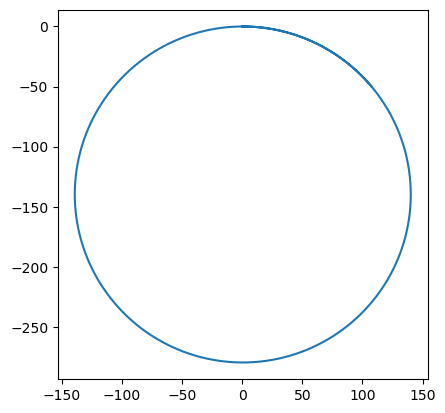

In [335]:
plt.plot([v[0] for v in poss], [v[1] for v in poss])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')